Derive spec2vec embeddings of MS/MS spectra

In [1]:
import os
from matchms.importing import load_from_json
folder_name = 'C:\\Users\\Gosia\\Documents\\gnps_from_simon'
spectra = []
for f in os.listdir(folder_name):
    if f.endswith('.txt'):
        spectra += load_from_json(os.path.join(folder_name,f ))
        print('processed',f)
spectrums = spectra

processed 0000.txt
processed 0001.txt
processed 0002.txt
processed 0003.txt
processed 0004.txt
processed 0005.txt
processed 0006.txt
processed 0007.txt
processed 0008.txt
processed 0009.txt
processed 0010.txt
processed 0011.txt
processed 0012.txt
processed 0013.txt
processed 0014.txt
processed 0015.txt
processed 0016.txt
processed 0017.txt
processed 0018.txt
processed 0019.txt
processed 0020.txt
processed 0021.txt
processed 0022.txt
processed 0023.txt
processed 0024.txt
processed 0025.txt
processed 0026.txt
processed 0027.txt
processed 0028.txt
processed 0029.txt
processed 0030.txt
processed 0031.txt
processed 0032.txt
processed 0033.txt
processed 0034.txt
processed 0035.txt
processed 0036.txt
processed 0037.txt
processed 0038.txt
processed 0039.txt
processed 0040.txt
processed 0041.txt
processed 0042.txt
processed 0043.txt
processed 0044.txt
processed 0045.txt
processed 0046.txt
processed 0047.txt
processed 0048.txt
processed 0049.txt
processed 0050.txt
processed 0051.txt
processed 00

processed 0432.txt
processed 0433.txt
processed 0434.txt
processed 0435.txt
processed 0436.txt
processed 0437.txt
processed 0438.txt
processed 0439.txt
processed 0440.txt
processed 0441.txt
processed 0442.txt
processed 0443.txt
processed 0444.txt
processed 0445.txt
processed 0446.txt
processed 0447.txt
processed 0448.txt
processed 0449.txt
processed 0450.txt
processed 0451.txt
processed 0452.txt
processed 0453.txt
processed 0454.txt
processed 0455.txt
processed 0456.txt
processed 0457.txt
processed 0458.txt
processed 0459.txt
processed 0460.txt
processed 0461.txt
processed 0462.txt
processed 0463.txt
processed 0464.txt
processed 0465.txt
processed 0466.txt
processed 0467.txt
processed 0468.txt
processed 0469.txt
processed 0470.txt
processed 0471.txt
processed 0472.txt
processed 0473.txt
processed 0474.txt
processed 0475.txt
processed 0476.txt
processed 0477.txt
processed 0478.txt
processed 0479.txt
processed 0480.txt
processed 0481.txt
processed 0482.txt
processed 0483.txt
processed 04

processed 0864.txt
processed 0865.txt
processed 0866.txt
processed 0867.txt
processed 0868.txt
processed 0869.txt
processed 0870.txt
processed 0871.txt
processed 0872.txt
processed 0873.txt
processed 0874.txt
processed 0875.txt
processed 0876.txt
processed 0877.txt
processed 0878.txt
processed 0879.txt
processed 0880.txt
processed 0881.txt
processed 0882.txt
processed 0883.txt
processed 0884.txt
processed 0885.txt
processed 0886.txt
processed 0887.txt
processed 0888.txt
processed 0889.txt
processed 0890.txt
processed 0891.txt
processed 0892.txt
processed 0893.txt
processed 0894.txt
processed 0895.txt
processed 0896.txt
processed 0897.txt
processed 0898.txt
processed 0899.txt
processed 0900.txt
processed 0901.txt
processed 0902.txt
processed 0903.txt
processed 0904.txt
processed 0905.txt
processed 0906.txt
processed 0907.txt
processed 0908.txt
processed 0909.txt
processed 0910.txt
processed 0911.txt
processed 0912.txt
processed 0913.txt
processed 0914.txt
processed 0915.txt
processed 09

In [2]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process_classical(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

# apply filters to the data
spectrums_classical = [post_process_classical(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_classical = [s for s in spectrums_classical if s is not None]

print("{} remaining spectra.".format(len(spectrums_classical)))

95320 remaining spectra.


In [3]:
try:
    del(spectrums)
except:
    pass
try:
    del(spectra)
except:
    pass
import numpy as np

In [4]:
import bisect
# a new filter to check if there is a fragment within N ppm of the precursor
def has_frag(spectrum, mz, tol, tol_units='absolute'):
    if tol_units == 'ppm':
        di = tol_ppm*mz/1e6
    else:
        di = tol
    min_mz = mz - di
    max_mz = mz + di
    pos = bisect.bisect_right(spectrum.peaks[0], min_mz)
    pos2 = bisect.bisect_right(spectrum.peaks[0], max_mz)
    if pos == pos2:
        return None
    else:
        max_pos = pos + np.argmax(spectrum.peaks[1][pos:pos2])
        return (spectrum.peaks[0][max_pos], spectrum.peaks[1][max_pos])

In [5]:
spec_with_precursor = [s for s in spectrums_classical if has_frag(s, s.metadata['precursor_mz'], 0.2)  is not None]

In [6]:
del(spectrums_classical)

# IGNORE THE ABOVE
## Just load the specs.json

In [12]:
from matchms.importing import load_from_json
json_file_name = 'C:\\Users\\Gosia\\Desktop\\FDR-datsets\\specs.json'
spec_with_precursor = load_from_json(json_file_name)

In [13]:
inchi_dict = {}
for s in spec_with_precursor:
    ik = s.metadata['inchikey_inchi']
    init_ik = ik.split('-')[0]
    if not init_ik in inchi_dict:
        inchi_dict[init_ik] = [s]
    else:
        inchi_dict[init_ik].append(s)

In [14]:
library_spec = set()
query_spec = set()
singletons = set([i for i,v in inchi_dict.items() if len(v) == 1])
multis = set([i for i,v in inchi_dict.items() if len(v) > 1])
print(len(singletons), len(multis))

2668 1890


In [15]:
query_size = 1500
library_size = 2500
import numpy as np

In [16]:
used = set()
query_keys = np.random.choice(list(multis), size=query_size, replace=False)
other_library_keys = np.random.choice(list(singletons), size=library_size-query_size, replace=False)
query_spec = []
library_spec = []
for q in query_keys:
    ss = np.random.choice(inchi_dict[q], size=2, replace=False)
    query_spec.append(ss[0])
    library_spec.append(ss[1])
for o in other_library_keys:
    ss = np.random.choice(inchi_dict[o], size=1, replace=False)
    library_spec.append(ss[0])

assert len(library_spec) == library_size
assert len(query_spec) == query_size

In [18]:
import sys
import os
folder_name = 'C:\\Users\\Gosia\\Desktop'
sys.path.append(os.path.join(folder_name,'\\FDR-Metabolomics\\src'))
import passatuto_parser as pp


Create spectrum "documents"

In [19]:
from spec2vec import Spec2Vec
from spec2vec import SpectrumDocument
spectrums_lib = library_spec
spectrums_query = query_spec
documents_query = [SpectrumDocument(s, n_decimals=2) for s in spectrums_query]
documents_lib = [SpectrumDocument(s, n_decimals=2) for s in spectrums_lib]
print(documents_query)


[<spec2vec.SpectrumDocument.SpectrumDocument object at 0x000002081900F1F0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000002081900F250>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000002081900F1C0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000002081900F340>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000002081900F370>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000002081900F100>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000002081900F280>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x00000208197BDE50>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x00000208197BDDC0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x00000208197BDDF0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x00000208197BDCA0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x00000208197BDD00>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000002081980FB50>, <spec2vec.SpectrumDocume

In [20]:
from spec2vec.model_building import train_new_word2vec_model
path_models = os.path.join(folder_name, "trained_models")

model_file = os.path.join(path_models, "spec2vec_librarymatching_size_50.model")

iterations = [1, 3, 5, 10]

#Train model with size 10 and default parameters

model = train_new_word2vec_model(documents_lib, iterations, model_file, size = 50)

The value of size is set from 300 (default) to 50
  Epoch 1 of 10.Change in loss after epoch 1: 113518.2265625
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_librarymatching_size_50_iter_1.model
  Epoch 2 of 10.Change in loss after epoch 2: 83416.5078125
  Epoch 3 of 10.Change in loss after epoch 3: 77438.453125
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_librarymatching_size_50_iter_3.model
  Epoch 4 of 10.Change in loss after epoch 4: 71397.34375
  Epoch 5 of 10.Change in loss after epoch 5: 90625.0
Saving model with name: C:\Users\Gosia\Desktop\trained_models\spec2vec_librarymatching_size_50_iter_5.model
  Epoch 6 of 10.Change in loss after epoch 6: 66753.09375
  Epoch 7 of 10.Change in loss after epoch 7: 65434.8125
  Epoch 8 of 10.Change in loss after epoch 8: 63064.3125
  Epoch 9 of 10.Change in loss after epoch 9: 81283.125
  Epoch 10 of 10.Change in loss after epoch 10: 59228.25
Saving model with name: C:\Users\Gosia\Desktop\tr


Derive embeddings

In [21]:
#from tqdm.notebook import tqdm  # optional, just to get a progress bar
from spec2vec.vector_operations import calc_vector


intensity_weighting_power = 0.5
allowed_missing_percentage = 15 # specify the maximum (weighted) fraction of the spectrum that is allowed to be missing

vector_size = model.vector_size
print(f"Embedding vector size: {vector_size}")

embeddings_spec2vec_lib = np.zeros((len(documents_lib), vector_size), dtype="float")
for i, doc in enumerate(documents_lib):
    embeddings_spec2vec_lib[i, 0:vector_size] = calc_vector(model, doc,
                                                        intensity_weighting_power,
                                                        allowed_missing_percentage)

Embedding vector size: 50


In [22]:
print([np.round(x, 4) for x in embeddings_spec2vec_lib])

[array([-6.0517, -2.0567,  0.688 , -0.3508,  2.2436,  5.3222,  9.794 ,
       -0.5609,  0.8332,  0.4722, -2.2244, -1.3805, -2.2768, -0.5844,
       -4.2687, -0.2959, -3.3116, -6.1174,  1.7368,  0.6101,  7.8659,
       -6.0023, -1.7067,  5.435 ,  6.7697,  2.9656, -1.5619, -2.3443,
       -9.5252,  1.9995,  1.7838,  1.7394, -7.1559, -2.3587,  2.4363,
        2.2808, -7.1392,  0.8238, -7.3162,  0.6901, -0.0502,  3.3535,
       -6.8435, -0.6566,  4.9555, -0.6801, -0.9959, -2.0691, -2.9462,
       -3.3435]), array([-0.0805,  4.6859, -2.9584, -3.6476, -9.7056, 11.7067, -2.9257,
       -5.4239,  5.1705, -5.0809,  0.819 ,  1.1407, -9.5015, -0.791 ,
       -2.5958,  3.3459, -0.1916, -2.6192, -1.5756,  4.8417, -1.2953,
        3.4392, -2.4095, -0.7778,  3.4157,  3.4606,  1.7338,  1.8284,
       -6.9911, -1.7075,  1.8405,  3.5045,  0.0591,  5.1615, -3.0185,
       -4.0119,  1.2254,  1.3414, -4.5776,  3.0123, -5.3553,  0.9988,
       -3.1741, -1.5164, -1.0896,  8.6212,  5.2661, -5.0462,  0.3815,
 

In [23]:
import numpy as np
from sklearn.mixture import GaussianMixture

gm = GaussianMixture().fit(embeddings_spec2vec_lib)
gm.means_
gm.covariances_[0]

array([[ 531.82997905, -231.59029998,  227.15186737, ...,  -48.79440571,
         277.06188463,  305.72007938],
       [-231.59029998,  539.06897613, -240.95784229, ...,  258.04975934,
        -179.22755338, -178.43049981],
       [ 227.15186737, -240.95784229,  399.19502677, ...,   18.14820328,
         -12.74489011,  155.23461092],
       ...,
       [ -48.79440571,  258.04975934,   18.14820328, ...,  308.23410159,
        -146.64771915,  -39.30038708],
       [ 277.06188463, -179.22755338,  -12.74489011, ..., -146.64771915,
         293.97878748,  158.7925336 ],
       [ 305.72007938, -178.43049981,  155.23461092, ...,  -39.30038708,
         158.7925336 ,  189.44292104]])

# Creating knockoffs


In [24]:
import copy
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy.random import uniform, seed
from matplotlib import cm
from scipy.stats import multivariate_normal
from spec2vec.SpectrumDocument import SpectrumDocument
from matchms import Spectrum


def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

# seed(1234)
nDim = len(embeddings_spec2vec_lib[0])
# define the mean and covariance 
mu = gm.means_[0]
Sigma = gm.covariances_[0]
D = np.eye(nDim)*0.16

joint_cov = np.hstack((Sigma, Sigma-D))
joint_cov = np.vstack((joint_cov, np.hstack((Sigma-D,Sigma))))

print(is_pos_def(joint_cov))

A = np.eye(nDim) - np.dot(D,np.linalg.inv(Sigma))

all_knockoffs = []
# generate a sample
for point in embeddings_spec2vec_lib:
    # generate N knock-offs
    kmu = np.dot(np.dot(D,np.linalg.inv(Sigma)),mu)
    B = np.dot(A, point.T)
    kmu += B
    kSigma = 2*D - np.dot(np.dot(D,np.linalg.inv(Sigma)), D)
    ko = np.random.multivariate_normal(kmu.flatten(), kSigma, 1)
    all_knockoffs.append(ko)


knockoff_documents = []
for ko,v,d in zip(all_knockoffs,embeddings_spec2vec_lib,documents_lib):
    #print("knockoff:",ko,"vector",v,"document",d)
    #print("\n")
    e = copy.deepcopy(d)
    e._obj.set('inchi', 'knockoff')
    e._obj.set('vector', ko[0])
    knockoff_documents.append(e)
print(knockoff_documents)

False


<ipython-input-24-44dda386f321>:38: RuntimeWarning: covariance is not positive-semidefinite.
  ko = np.random.multivariate_normal(kmu.flatten(), kSigma, 1)


[<spec2vec.SpectrumDocument.SpectrumDocument object at 0x00000208960DE220>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000002087F8B9BE0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000002087F8B9D90>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000002087F8B9F40>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000020896F5F130>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000020896F5F2E0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000020896F5F490>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000020896F5F640>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x000002087EF66730>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000020896F5F850>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000020896F5FA00>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000020896F5FBB0>, <spec2vec.SpectrumDocument.SpectrumDocument object at 0x0000020896F5FD60>, <spec2vec.SpectrumDocume

In [25]:
import importlib
import cosine_calc
importlib.reload(cosine_calc)
hits_knockoffs, _ = cosine_calc.get_hits(documents_query, knockoff_documents, decoys=True, spec2vec_model=model,
                                                        intensity_weighting_power=intensity_weighting_power,
                                                        allowed_missing_percentage=allowed_missing_percentage)
hits, _ = cosine_calc.get_hits(documents_query, documents_lib, spec2vec_model=model,
                                                        intensity_weighting_power=intensity_weighting_power,
                                                        allowed_missing_percentage=allowed_missing_percentage)


Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.51%.
Found 9 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.75%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 48.30%.
unable to process (2S)-N-[(2E,4E,6S,7R)-7-{(2S,3S,4R,5R)-3,4-Dihydroxy-5-[(1E,3E,5E)-7-(4-hydroxy-1-methyl-2-oxo-1,2-dihydro-3-pyridinyl)-6-methyl-7-oxo-1,3,5-heptatrien-1-yl]tetrahydro-2-furanyl}-6-methoxy-5-methyl-2,4-octadien-1-yl]-2-{(2R,3R,4R,6

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.08%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.08%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.08%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.08%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.08%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.08%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.08%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.08%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.17%.
unable to process (3beta,9xi,16alpha

Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.01%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.01%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.01%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.01%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.01%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.01%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.01%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.01%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.01%.
Found 13 word(s) missing in 

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.03%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.03%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.03%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.03%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.03%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.76%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.76%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.76%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.76%.
Found 6 word(s) missing in the model.

Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.92%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.92%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.92%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.92%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.92%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.92%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.92%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.92%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.92%.
Found 14 word(s) mi

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.00%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.00%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.00%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.00%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.00%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.00%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.00%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.00%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 13.00%.
Found 2 word(s) missing in t

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 49.68%.
unable to process DescladinoseAzithromycin
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.77%.
unable to process Delphinidin-3-rutinoside
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.00%.
Found 11 word(s) missing in the model. Weighted missin

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.07%.
Found 1 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.72%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.72%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.72%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.72%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.72%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.72%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.72%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.72%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.72%.
Found 1 word(s) missing in the model.

Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.42%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.42%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.42%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.42%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.42%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.88%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.88%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.88%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.88%.
Found 7 word(s) missing in the m

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.44%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.79%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.79%.
Found 5 word(s) missing in the model.

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.76%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 14.35%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.49%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.49%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.49%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.49%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.49%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.49%.
Found 3 word(s) missing in the model

Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.79%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.79%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.79%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.79%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.24%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.24%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.24%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.24%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.11%.
Found 23 word(s) missing in the 

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.26%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.26%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.26%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.26%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.26%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 2 word(s) missing in the model.

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.12%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.12%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.12%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.12%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.12%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.12%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.12%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.12%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.12%.
Found 8 word(s) missing in the model.

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.61%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.61%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.61%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.61%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.61%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.61%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.61%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.61%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.61%.
Found 2 word(s) missing in the model.

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.19%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.19%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.19%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.19%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.19%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 56.84%.
unable to process NNEI - N-1-naphthalenyl-1-pentyl-1H-indole-3-carboxamide 40 NCE
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.12%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.12%.
Found 5 word(s) missing in the model. Weighted missing p

Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.93%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.93%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.93%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.93%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.93%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.93%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.70%.
unable to process (7E)-11-Hydroxy-3-isobutyl-4,5,8,13,13-pentamethyl-3,3a,4,6a,9,10,11,11a,14a,15-decahydro-1H-[1,3]dioxolo[9,10]oxacyclododecino[2,3-d]isoindole-1,16(2H)-dione
Found 2 word(s) missing in the model. Weighted missing percentage n

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.39%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.39%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.39%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.39%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.39%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.39%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.39%.
Found 15 word(s) missing in th

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.98%.
Found 7 word(s) missing in the model.

Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.37%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.37%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.37%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.29%.
unable to process Triphenyl phosphate
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.07%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.07%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.07%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.07%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.39%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.26%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.26%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.34%.
unable to process 2-[[5-[[2,12-dihydroxy-4,4,10,13,14-pentamethyl-17-(1,5,6-trihydroxy-6-methylheptan-2-yl)-2,3,5,6,7,11,12,15,16,17-decahydro-1H-cyclopenta[a]phenanthren-3-yl]oxy]-3-hydroxy-3-methyl-5-oxopentanoyl]amino]acetic acid [IIN-based on: CCMSLIB00000848867]
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the giv

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.34%.
Found 1 word(s) missing in the model.

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.36%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.36%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.37%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.37%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.37%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.37%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.37%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.37%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.37%.
Found 3 word(s) missing in the mode

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.00%.
Found 8 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.35%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.55%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.55%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.55%.
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.14%.
Found 10 word(s) missing in the mode

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.30%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.37%.
Found 22 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.37%.
Found 22 word(s) missing in the m

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.40%.
Found 1 word(s) missing in the model.

Found 32 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.69%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.73%.
unable to process 6-[(2S,3R,4S,5S,6R)-4,5-dihydroxy-6-(hydroxymethyl)-3-[(2S,3R,4R,5R,6S)-3,4,5-trihydroxy-6-methyloxan-2-yl]oxyoxan-2-yl]-5,7-dihydroxy-2-(4-hydroxyphenyl)chromen-4-one
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.99%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.99%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.99%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.99%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.99%.
Found 9 word(s) missing in the model. Weighted missing percent

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.62%.
unable to process 2,3,8,9,10-pentamethoxy-6a,11a-dihydro-6H-[1]benzofuro[3,2-c]chromene [IIN-based on: CCMSLIB00000847214]
Found 37 word(s) missing in the model. Weighted missing percentage not covered by the given model is 64.14%.
unable to process Apratoxin G
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 46.03%.
unable to process (1R,2R,5R,7R,10S,11S,14S,16S,19R,20R,23R,25R,28S,29S,32S,34S)-5,23-Diethyl-2,11,14,20,29,32-hexamethyl-4,13,22,31,37,38,39,40-octaoxapentacyclo[32.2.1.1~7,10~.1~16,19~.1~25,28~]tetracontane-3,12,21,30-tetrone
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.83%.
unable to process Propylthiouracil
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.50%.
Found 5 word(s) missing in the model. Weight

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 80.70%.
unable to process hyocholic acid
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Fou

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.36%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.36%.
Found 1 word(s) missing in the model.

Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.67%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.67%.
Found 4 word(s) missing in the

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.02%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.02%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.02%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.02%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.02%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.02%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.82%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.82%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.82%.
Found 13 word(s) missing in 

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.58%.
Found 1 word(s) missing in the model.

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.71%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.71%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.71%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.71%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.71%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.71%.
Found 47 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.91%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 58.38%.
unable to process Daunomycin
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 16.02%.
unabl

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.76%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.18%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.18%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.18%.
Found 9 word(s) missing in the mod

Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.40%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.40%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.40%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.40%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.40%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.40%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.40%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.40%.
Found 42 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.40%.
Found 2 word(s) missing in t

Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 14 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.35%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.62%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.62%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.62%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.62%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.62%.
Found 3 word(s) missing in the mo

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.18%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.18%.
Found 1 word(s) missing in the model.

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 27.93%.
unable to process 8-Benzoyl-2-[(3Z)-1,2-dihydroxy-3-hexen-1-yl]-9-hydroxy-8-methoxy-3-methyl-1-oxa-7-azaspiro[4.4]non-2-ene-4,6-dione
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.99%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.99%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.99%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.99%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.70%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.70%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.70%.
Found

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.14%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.14%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.14%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.14%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.14%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.70%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.21%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.21%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.21%.
Found 3 word(s) missing in the model.

Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.93%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.93%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.93%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.93%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.93%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.74%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.74%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.74%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.74%.
Found 13 word(s) missing in 

Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.44%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.44%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.44%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.44%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.44%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.44%.
Found 29 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.44%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.35%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.35%.
Found 3 word(s) missing in the

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.56%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.56%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.56%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.56%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.56%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.56%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.56%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.56%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.56%.
Found 2 word(s) missing in the model.

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.85%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.85%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.85%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.85%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.85%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.01%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.01%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.01%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.01%.
Found 13 word(s) missing in the m

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.93%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.93%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.80%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.80%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.80%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.80%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.80%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.80%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 12.80%.
Found 7 word(s) missing in t

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.66%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.66%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.66%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.66%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.66%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.66%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.66%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.66%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.66%.
Found 1 word(s) missing in the model.

Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.30%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.30%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.30%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.30%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.30%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.30%.
Found 11 word(s) missing in the model. Weighted missing percentage not covered by the given model is 10.30%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.46%.
Found 17 word(s) miss

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.60%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.60%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.60%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.60%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.60%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.60%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.60%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.60%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.60%.
Found 3 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.27%.
Found 1 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.22%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 67.19%.
unable to process 3H-4,11b-Propano-1H-oxireno[1',5']cyclopenta[1',2':5,6]naphtho[1,2-c]pyran-11(9H)-one, 10,14-bis(acetyloxy)-9-(3-furanyl)decahydro-3,6,12-trihydroxy-4,6a,9a-trimethyl-, (3R,4aR,6R,6aS,6bS,7aR,9S,9aR,10R,11aR,11bS,12S,14R)-
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.30%.
Found 4 w

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.47%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.17%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.17%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.17%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.17%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.17%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.17%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.17%.
Found 2 word(s) missing in the model.

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.14%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.14%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.14%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.14%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.34%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.32%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.32%.
Found 2 word(s) missing in the mo

Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.22%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.22%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.22%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.22%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.22%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.22%.
Found 28 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.22%.
Found 56 word(s) missing in the model. Weighted missing percentage not covered by the given model is 36.52%.
unable to process Cyanolide A
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model i

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.83%.
Found 1 word(s) missing in the model.

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.41%.
unable to process ABEE
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 33.57%.
unable to process BML00292 Nicergoline
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 43.14%.
unable to process Streptomycin
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.03%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.03%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.03%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.03%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.03%.
Found 8 word(s) missing in the model. Weighted m

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.41%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.41%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.41%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.41%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.41%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.41%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.41%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.41%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.12%.
Found 8 word(s) missing in the model.

Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.44%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.44%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.44%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.44%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.44%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 22.49%.
unable to process (3S,6R,9S,12R,15S,18R)-3,9,15-Tribenzyl-6,12,18-triisopropyl-4,10,16-trimethyl-1,7,13-trioxa-4,10,16-triazacyclooctadecane-2,5,8,11,14,17-hexone
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.67%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by t

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.10%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.10%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.10%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.10%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.10%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.10%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.10%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.10%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.10%.
Found 2 word(s) missing in the model.

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.73%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.73%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.73%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.73%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 18.29%.
unable to process Pesticide2_Furathiocarb_C18H26N2O5S_Butyl 2,3-dihydro-2,2-dimethylbenzofuran-7-yl-N,N'-dimethyl-N,N'-thiodicarbamate
Found 41 word(s) missing in the model. Weighted missing percentage not covered by the given model is 28.15%.
unable to process 2-[4,5-dihydroxy-2-(hydroxymethyl)-10-oxo-9-[3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]anthracen-9-yl]-1,8,10-trihydroxy-6-(hydroxymethyl)-10-[3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]anthracen-9-o

Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.19%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.19%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.95%.
Found 15 word(s) missing in the model

Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.49%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.49%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.49%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.49%.
Found 12 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.49%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.34%.
Found 1 word(s) missing in the m

Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.47%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 25.04%.
unable to process 5-Oxoproline
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.76%.
Foun

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.26%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 21.34%.
unable to process 2-[[5-[[2,12-dihydroxy-4,4,10,13,14-pentamethyl-17-(1,5,6-trihydroxy-6-methylheptan-2-yl)-2,3,5,6,7,11,12,15,16,17-decahydro-1H-cyclopenta[a]phenanthren-3-yl]oxy]-3-hydroxy-3-methyl-5-oxopentanoyl]amino]acetic acid [IIN-based on: CCMSLIB00000848867]
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.98%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.98%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.35%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.35%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the gi

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.42%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.42%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.42%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.42%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.42%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.42%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.42%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.42%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.42%.
Found 3 word(s) missing in the model.

Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.87%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.87%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.87%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.87%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.87%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.87%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.87%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 9.87%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.71%.
Found 1 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.13%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.13%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.13%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.13%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.13%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.13%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.13%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.13%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.13%.
Found 11 word(s) missing in the model

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.68%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.68%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.68%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.68%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.68%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.68%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.68%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 38.59%.
unable to process (9E,15E,19E)-3-(2-amino-2-oxoethyl)-11,13-dihydroxy-14,21-dimethoxy-8,10,12-trimethyl-7,21-dioxohenicosa-9,15,19-trienoic aci

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.45%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.45%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.45%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.45%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.45%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.45%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.45%.
Found 8 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.04%.
unable to process (2E)-3-(4-Methoxyphenyl)-1-(1-pyrrolidinyl)-2-propen-1-one
Found 36 word(s) missing in the model. Weighted missing percentage

Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.69%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.69%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.69%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.69%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.69%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.69%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.32%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.32%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.32%.
Found 3 word(s) missing in the model.

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.75%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.82%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.82%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.82%.
Found 4 word(s) missing in the model.

Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.02%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.02%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.02%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.02%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.02%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.02%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.02%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.02%.
Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 31.35%.
unable to process FFF00162 Campeste

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 46.03%.
unable to process (1R,2R,5R,7R,10S,11S,14S,16S,19R,20R,23R,25R,28S,29S,32S,34S)-5,23-Diethyl-2,11,14,20,29,32-hexamethyl-4,13,22,31,37,38,39,40-octaoxapentacyclo[32.2.1.1~7,10~.1~16,19~.1~25,28~]tetracontane-3,12,21,30-tetrone
Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 17.83%.
unable to process Propylthiouracil
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.50%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.50%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.50%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given model is 7.50%.
Found 5 word(s) missing in the model. Weighted missing percentage not covered by the given mo

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 41.85%.
unable to process 2-(4-methoxyphenyl)chromen-4-one [IIN-based on: CCMSLIB00000847204]
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.48%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.48%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.48%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.48%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.48%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.48%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.48%.
Found 2 word(s) missing in the model. Weighted missing pe

Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.79%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.79%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.79%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.79%.
Found 15 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.79%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.21%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.21%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.21%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.21%.
Found 1 word(s) missing in the m

Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 20 word(s) missing in the model. Weighted missing percentage not covered by the given model is 6.58%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.67%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.67%.
Found 4 word(s) missing in the

Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.52%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.52%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.52%.
Found 4 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.52%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 15.33%.
unable to process Exumolide A
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 2.23%.
Found 

Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.89%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.89%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.89%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.89%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.01%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.01%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.01%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.01%.
Found 31 word(s) missing in the model. Weighted missing percentage not covered by the given model is 41.78%.
unable to process Ergosterol
Found 

Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.65%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.65%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.65%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.65%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.65%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.65%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.65%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.65%.
Found 7 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.65%.
Found 7 word(s) missing in the model.

Found 23 word(s) missing in the model. Weighted missing percentage not covered by the given model is 29.32%.
unable to process 7-Dehydrocholesterol
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.29%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.29%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.29%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.29%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 8.29%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.19%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.19%.
Found 2 word(s) missing in the model. Weighted missing percentage not covered by the given model is 1.1

Found 10 word(s) missing in the model. Weighted missing percentage not covered by the given model is 24.61%.
unable to process ROSMARINATE
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.40%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.40%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.40%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.40%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.89%.
Found 3 word(s) missing in the model. Weighted missing percentage not covered by the given model is 40.72%.
unable to process Trimethylsulfonium
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.43%.
Found 1 word(s) missing in the model. Weighted missing percentage not cove

Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.13%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.13%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.13%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.13%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.13%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.13%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.13%.
Found 9 word(s) missing in the model. Weighted missing percentage not covered by the given model is 11.13%.
Found 6 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.43%.
Found 6 word(s) missing in th

Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 4.00%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 1 word(s) missing in the model. Weighted missing percentage not covered by the given model is 0.56%.
Found 1 word(s) missing in the model.

Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.93%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.93%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.93%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.93%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.93%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.93%.
Found 17 word(s) missing in the model. Weighted missing percentage not covered by the given model is 5.93%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.74%.
Found 13 word(s) missing in the model. Weighted missing percentage not covered by the given model is 3.74%.
Found 13 word(s) missing in 

In [26]:
# Calculating true q-value scores
from q_value_calc import calculate_q_value
q_list_true = calculate_q_value(hits)

In [27]:
# Calculating estimated q-value scores
q_list_estimated = calculate_q_value(hits+hits_knockoffs,True)


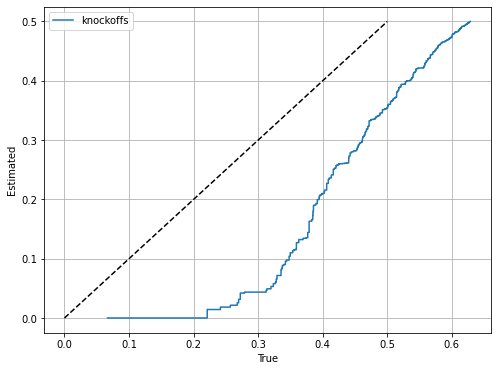

In [28]:
# plot estimated and true q-values
def combine_true_est(q_val_true,q_val_est):
    res = []
    q_idx = 0
    for q_e, _, score in q_val_est:
        while q_idx < len(q_val_true)-1 and q_val_true[q_idx+1][2] >= score:
            q_idx += 1
        res.append((score, q_val_true[q_idx][0], q_e))
    return res
        
scores, trues, estimateds = zip(*combine_true_est(q_list_true, q_list_estimated))

import plot_q_vals
plot_q_vals.plot_q_vals( {'knockoffs':(trues,estimateds)})

In [29]:
len(hits)


1314

In [30]:
documents_query_s2v = documents_query

In [31]:


test_matches_s2v = []

cosine_thresholds = np.arange(0,1,0.05)

# for every query
# find its 'hit'
# if True match, 1
# if False match, 0
# otherwise, -1

hit_dict = { hit.query:hit for hit in hits }

for threshold in cosine_thresholds:
    print(f"Checking matches for spec2vec score > {threshold:.2f}")
    test_matches = []
    for doc in documents_query:
        if doc in hit_dict and hit_dict[doc].score > threshold:
            hit = hit_dict[doc]
            test_matches.append(1 * hit.hit)                
        else:
            test_matches.append(-1)

    # Make arrays from lists:
    test_arr = np.array(test_matches)
    test_matches_s2v.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])
    
print(test_matches_s2v)

Checking matches for spec2vec score > 0.00
Checking matches for spec2vec score > 0.05
Checking matches for spec2vec score > 0.10
Checking matches for spec2vec score > 0.15
Checking matches for spec2vec score > 0.20
Checking matches for spec2vec score > 0.25
Checking matches for spec2vec score > 0.30
Checking matches for spec2vec score > 0.35
Checking matches for spec2vec score > 0.40
Checking matches for spec2vec score > 0.45
Checking matches for spec2vec score > 0.50
Checking matches for spec2vec score > 0.55
Checking matches for spec2vec score > 0.60
Checking matches for spec2vec score > 0.65
Checking matches for spec2vec score > 0.70
Checking matches for spec2vec score > 0.75
Checking matches for spec2vec score > 0.80
Checking matches for spec2vec score > 0.85
Checking matches for spec2vec score > 0.90
Checking matches for spec2vec score > 0.95
[[488, 825, 187], [488, 822, 190], [488, 819, 193], [488, 819, 193], [488, 819, 193], [488, 816, 196], [488, 812, 200], [487, 809, 204], [48

Text(0, 0.5, 'true positive rate')

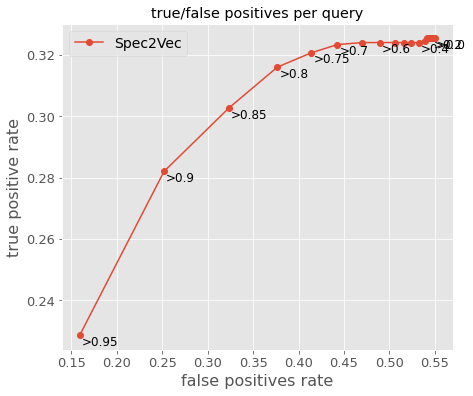

In [32]:
min_match = 6
test_matches_s2v_arr = np.array(test_matches_s2v)

thresholds = np.arange(0, 1, 0.05)
label_picks = [0,4,8,12,14,15,16,17,18,19]

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
num_max = np.sum(test_matches_s2v_arr[0,:])

plt.plot(test_matches_s2v_arr[:,1]/num_max, test_matches_s2v_arr[:,0]/num_max, 
         'o-', label='Spec2Vec')
for i, threshold in enumerate(thresholds):
    if i in label_picks:
        plt.annotate(">{:.2}".format(threshold),
                    (test_matches_s2v_arr[i,1]/num_max, test_matches_s2v_arr[i,0]/num_max),
                    textcoords="offset points", xytext=(2,-10), fontsize=12)

#plt.plot(test_matches_ROC_min2_arr[:,1]/num_max, test_matches_ROC_min2_arr[:,0]/num_max, 
#         '.--', color='black', alpha=0.5, label='cosine (min match = 2)')

plt.title('true/false positives per query')
plt.legend(fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('false positives rate', fontsize=16)
plt.ylabel('true positive rate', fontsize=16)